# Semantic Separation

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn import preprocessing, metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import os
from skimage import img_as_ubyte
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage import feature, io, color
import random
from sklearn.utils import shuffle

In [2]:
!git clone https://github.com/siddharth-iyer1/dsl_final_project_ai_vs_real_art.git

Cloning into 'dsl_final_project_ai_vs_real_art'...
remote: Enumerating objects: 5269, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 5269 (delta 66), reused 88 (delta 21), pack-reused 5125
Receiving objects: 100% (5269/5269), 254.14 MiB | 22.05 MiB/s, done.
Resolving deltas: 100% (67/67), done.
Updating files: 100% (6840/6840), done.


In [160]:
def load_and_extract_features(folder_path, label, alpha=1.0, beta=0.0):
    features = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):
            image = imread(os.path.join(folder_path, filename))
            grayscale_image = rgb2gray(image)
            lbp_features = extract_lbp_features(grayscale_image)
            features.append(lbp_features)
            labels.append(label)
    return features, labels

In [161]:
real_directory = '/content/dsl_final_project_ai_vs_real_art/ai/ai_vs_real/REAL'
fake_directory = '/content/dsl_final_project_ai_vs_real_art/ai/ai_vs_real/FAKE'

In [187]:
def extract_lbp_features(image, P=8, R=1):
    lbp = local_binary_pattern(image, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

In [188]:
real_features, real_labels = load_and_extract_features(real_directory, 0)
fake_features, fake_labels = load_and_extract_features(fake_directory, 1)

In [189]:
x_data = np.concatenate((real_features, fake_features), axis=0)
x_data_shuffle = random.shuffle(x_data)
y_data = np.concatenate((real_labels, fake_labels), axis=0)
y_data_shuffle = random.shuffle(y_data)

In [190]:
print(x_data.shape)

(3410, 10)


In [191]:
print(y_data.shape)

(3410,)


In [192]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(real_features, real_labels, test_size=0.3, random_state=42)
X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(fake_features, fake_labels, test_size=0.3, random_state=42)

In [193]:
X_train = np.concatenate((X_real_train, X_fake_train), axis=0)
y_train = np.concatenate((y_real_train, y_fake_train), axis=0)
X_test = np.concatenate((X_real_test, X_fake_test), axis=0)
y_test = np.concatenate((y_real_test, y_fake_test), axis=0)

In [194]:
x_train, y_train = shuffle(X_train, y_train, random_state=42)
x_test, y_test = shuffle(X_test, y_test, random_state=42)

In [195]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

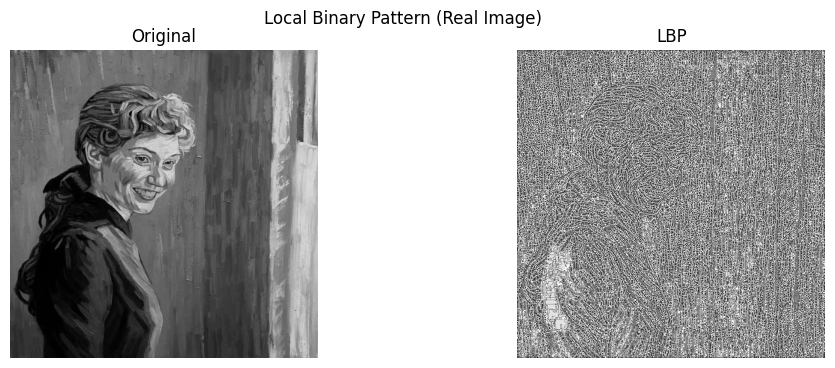

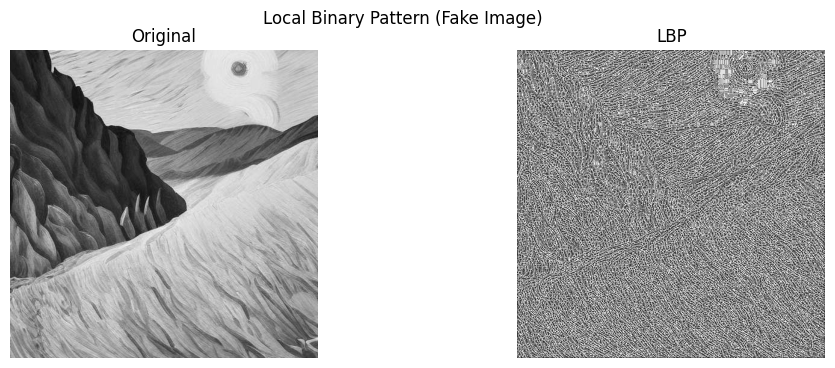

In [196]:
radius = 1
n_points = 8 * radius

def plot_lbp(original_image, lbp_image, title):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True)
    ax1.imshow(original_image, cmap=plt.cm.gray)
    ax1.axis('off')
    ax1.set_title('Original')

    ax2.imshow(lbp_image, cmap=plt.cm.gray)
    ax2.axis('off')
    ax2.set_title('LBP')

    plt.suptitle(title)
    plt.show()

real_path = '/content/dsl_final_project_ai_vs_real_art/ai/ai_vs_real/REAL/0.jpg'
fake_path = '/content/dsl_final_project_ai_vs_real_art/ai/ai_vs_real/FAKE/0.jpg'
image_real = imread(real_path)
image_fake = imread(fake_path)
gray_image_real = rgb2gray(image_real)
gray_image_fake = rgb2gray(image_fake)

lbp_real = local_binary_pattern(gray_image_real, n_points, radius, method='uniform')
lbp_fake = local_binary_pattern(gray_image_fake, n_points, radius, method='uniform')

plot_lbp(gray_image_real, lbp_real, 'Local Binary Pattern (Real Image)')
plot_lbp(gray_image_fake, lbp_fake, 'Local Binary Pattern (Fake Image)')

In [197]:
# Train SVM with GridSearchCV
svm_params = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}
svm = GridSearchCV(SVC(kernel='rbf'), svm_params, cv=5)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy_svm}")
print("SVM Results:")
print(metrics.classification_report(y_test, y_pred_svm))

Accuracy: 0.9609375
SVM Results:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       512
           1       0.96      0.96      0.96       512

    accuracy                           0.96      1024
   macro avg       0.96      0.96      0.96      1024
weighted avg       0.96      0.96      0.96      1024



In [198]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}
rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf}")
print("Random Forest Results:")
print(metrics.classification_report(y_test, y_pred_rf))

Accuracy: 0.9228515625
Random Forest Results:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       512
           1       0.93      0.91      0.92       512

    accuracy                           0.92      1024
   macro avg       0.92      0.92      0.92      1024
weighted avg       0.92      0.92      0.92      1024



In [199]:
nn = Sequential()
nn.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
nn.add(Dense(1, activation='sigmoid'))
nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0)
y_pred_nn = (nn.predict(X_test) > 0.5).astype(int)

accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Accuracy: {accuracy_nn}")
print("Neural Network Results:")
print(metrics.classification_report(y_test, y_pred_nn))

32/32 [==============================] - 0s 2ms/step
Accuracy: 0.9365234375
Neural Network Results:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       512
           1       0.95      0.92      0.94       512

    accuracy                           0.94      1024
   macro avg       0.94      0.94      0.94      1024
weighted avg       0.94      0.94      0.94      1024

